# **Business Understading**

# . Problem Statement

many real-world applications, datasets contain a very large number of variables (p can reach hundreds or even thousands), while the number of available observations remains relatively small. In such situations, only a small subset of variables actually carries meaningful information for predicting the target, whereas the remaining variables act merely as noise.

This high-dimensional setting creates several challenges for traditional machine learning models. Methods such as Random Forests, CART, and other standard tree-based algorithms often fail to correctly identify the truly informative variables,  avoid selecting irrelevant features during the splitting process, and  capture complex interactions between variables when these interactions do not manifest through marginal effects.

Therefore, the central question is:

How can we build a predictive model that remains accurate, stable, and reliable in high-dimensional environments (“large p, small n”), where only a small portion of the variables contains real signal, classical models struggle to detect important features, and crucial interactions may exist without any marginal effect?

# BO1 —
 **BO1 — Identify what truly matters within the available informatio**

Many pieces of information are collected, but only a small part is genuinely useful for understanding or predicting the outcome. The goal is to determine which elements are truly important and which ones do not contribute meaningfully


# DSO1

Build a model capable of reliably estimating variable importance in order to distinguish strong variables from noise variables, even when p ≫ n.





# BO2 —
** Improve the quality of the system’s decision-making process**

Ensure that the decision-support tool relies mainly on meaningful and relevant information, instead of being influenced by random or misleading elements, so that the results become more consistent and trustworthy..

# DSO2
Use optimization mechanisms such as reinforcement learning and variable muting to guide the model’s splits toward the variables that are truly relevant.



# BO3
# Ensure that the system remains reliable even with a lot of information but few case”

The organization needs a predictive tool that stays stable and dependable, even when there are many different pieces of information per case but only a limited number of cases available.

# DSO3

Develop a predictive model that remains statistically reliable even when the number of variables is significantly higher than the number of observations.




In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.inspection import permutation_importance



1. CHARGEMENT DU DATASET


In [27]:
# Cellule 2 — load_dataset (input-based)
def load_dataset():
    import pandas as pd
    file_path = input("Entrez le chemin complet du fichier dataset (ou glissez-le ici) :\n➡️ ").strip()
    if not file_path:
        print("Aucun fichier saisi.")
        return None, None
    try:
        if file_path.endswith('.csv'):
            try:
                df = pd.read_csv(file_path)
            except:
                df = pd.read_csv(file_path, sep=';')
        elif file_path.endswith(('.xls', '.xlsx')):
            df = pd.read_excel(file_path)
        elif file_path.endswith('.json'):
            df = pd.read_json(file_path)
        elif file_path.endswith('.data'):
            try:
                df = pd.read_csv(file_path, sep=',')
            except:
                df = pd.read_csv(file_path, sep=';')
        else:
            raise ValueError("Format non supporté.")
        print(f"\n📁 Chargé : {file_path}")
        print(f"Shape : {df.shape}")
        print(f"Colonnes : {list(df.columns)}")
        return df, file_path
    except Exception as e:
        print("Erreur:", e)
        return None, None

# Exécuter et charger
df, path = load_dataset()


Entrez le chemin complet du fichier dataset (ou glissez-le ici) :
➡️ /content/parkinsons.data

📁 Chargé : /content/parkinsons.data
Shape : (195, 24)
Colonnes : ['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


 2. DATA UNDERSTANDING

In [36]:
def data_understanding(df):
    print("="*60)
    print("🧠 DATA UNDERSTANDING")
    print("="*60)

    print("\n1️⃣ **Aperçu des données**")
    print(df.head())

    print("\n2️⃣ **Shape du dataset**")
    print(df.shape)

    print("\n3️⃣ **Types de données**")
    print(df.dtypes.value_counts())

    print("\n4️⃣ **Valeurs manquantes**")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    print("\n5️⃣ **Statistiques descriptives**")
    print(df.describe(include='all'))

    print("\n6️⃣ **Distribution des colonnes catégorielles**")
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in cat_cols:
        print(f"\nDistribution : {col}")
        print(df[col].value_counts(normalize=True).round(3) * 100)

3. MATRICE DE CORRÉLATIONS

In [37]:
def plot_correlations(df):
    print("\n" + "="*60)
    print("📊 MATRICE DE CORRÉLATIONS")
    print("="*60)

    num_cols = df.select_dtypes(include=[np.number]).columns

    if len(num_cols) < 2:
        print("Pas assez de variables numériques pour une matrice de corrélation.")
        return

    plt.figure(figsize=(14, 10))
    sns.heatmap(df[num_cols].corr(), annot=False, cmap='coolwarm', center=0)
    plt.title("Heatmap des corrélations entre variables numériques")
    plt.tight_layout()
    plt.show()


 4. DÉTECTION DES OUTLIERS

In [38]:
def detect_outliers(df):
    print("\n" + "="*60)
    print("⚠️ DÉTECTION DES VALEURS ABERRANTES (OUTLIERS)")
    print("="*60)

    num_cols = df.select_dtypes(include=[np.number]).columns

    if len(num_cols) == 0:
        print("Aucune colonne numérique.")
        return

    # Boxplots
    plt.figure(figsize=(15, 5))
    df[num_cols].boxplot()
    plt.title("Boxplot des variables numériques")
    plt.xticks(rotation=45)
    plt.show()

    # Détection via IQR
    outlier_report = []
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_report.append([col, len(outliers), f"{len(outliers)/len(df)*100:.2f}%"])

    print("\nRésumé des outliers :")
    print(pd.DataFrame(outlier_report, columns=["Variable", "Nb Outliers", "Pourcentage"]))

5. FEATURE ENGINEERING

In [39]:
def feature_engineering(df):
    print("\n" + "="*60)
    print("🛠️ FEATURE ENGINEERING")
    print("="*60)

    df2 = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns

    if len(num_cols) < 2:
        print("Pas assez de variables numériques pour créer des interactions.")
        return df2

    # Exemple : interactions simples
    print("\nAjout des interactions numériques :")
    for i in range(min(3, len(num_cols))):
        for j in range(i+1, min(4, len(num_cols))):
            new_col = f"{num_cols[i]}_x_{num_cols[j]}"
            df2[new_col] = df[num_cols[i]] * df[num_cols[j]]
            print(f"Créé : {new_col}")

    return df2

Définition des fonctions RTL (à exécuter AVANT pipeline)

In [40]:
# Cellule 5 — Fonctions RTL (define_variable_sets, apply_muting, add_linear_combinations, rlt_forest, compute_vi)
def define_variable_sets(X, y, n_top_p0=3, n_p1=5):
    model = ExtraTreesClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    model.fit(X, y)
    vi = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop=True)
    p0 = vi.head(n_top_p0).feature.tolist()
    p1 = vi.iloc[n_top_p0:n_top_p0 + n_p1].feature.tolist()
    p2 = vi.iloc[n_top_p0 + n_p1:].feature.tolist()
    return p0, p1, p2, vi

def apply_muting(X, p0, p1, p2, mode='partial'):
    Xc = X.copy()
    if mode == 'off':
        return Xc
    if mode == 'full':
        Xc.loc[:, p2] = 0
    elif mode == 'partial':
        Xc.loc[:, p2] = Xc.loc[:, p2] * 0.2
    return Xc

def add_linear_combinations(X, n_components=3, method='pca'):
    # uniquement sur les colonnes numériques
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler().fit(X[num_cols])
    Xs = scaler.transform(X[num_cols])
    if method == 'pca':
        comps = PCA(n_components=n_components, random_state=42).fit_transform(Xs)
    else:
        comps = FastICA(n_components=n_components, random_state=42).fit_transform(Xs)
    df_comps = pd.DataFrame(comps, index=X.index, columns=[f"LC{i+1}" for i in range(n_components)])
    X_new = pd.concat([X.reset_index(drop=True), df_comps.reset_index(drop=True)], axis=1)
    return X_new

def rlt_forest(X_train_, y_train_, X_test_):
    model = ExtraTreesClassifier(n_estimators=500, criterion='gini', max_features='sqrt', random_state=42, n_jobs=-1)
    model.fit(X_train_, y_train_)
    preds = model.predict(X_test_)
    return model, preds

def compute_vi(model, X_test_, y_test_):
    vi_emb = pd.Series(model.feature_importances_, index=X_test_.columns).sort_values(ascending=False)
    vi_perm_res = permutation_importance(model, X_test_, y_test_, n_repeats=20, random_state=42, n_jobs=-1)
    vi_perm = pd.Series(vi_perm_res.importances_mean, index=X_test_.columns).sort_values(ascending=False)
    return vi_emb, vi_perm


##Fonction RTL améliorer

In [41]:
def define_variable_sets(X, y, ntop_p0=3, n_p1=5, n_estimators=300, random_state=42):
    """
    Embedded model = ExtraTrees global.
    Retourne p0 (très fortes), p1 (moyennes), p2 (bruit) + DataFrame de VI.
    """
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X, y)
    vi = (
        pd.DataFrame({
            "feature": X.columns,
            "importance": model.feature_importances_
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    p0 = vi.head(ntop_p0)["feature"].tolist()
    p1 = vi.iloc[ntop_p0:ntop_p0 + n_p1]["feature"].tolist()
    p2 = vi.iloc[ntop_p0 + n_p1:]["feature"].tolist()
    return p0, p1, p2, vi


def apply_muting(X, p0, p1, p2, mode="partial", alpha=0.2):
    """
    Muting global inspiré de RLT.
    - off     : pas de muting
    - full    : p2 = 0
    - partial : p2 *= alpha
    """
    Xc = X.copy()
    if mode == "off":
        return Xc
    if mode == "full":
        Xc.loc[:, p2] = 0.0
    elif mode == "partial":
        Xc.loc[:, p2] = Xc.loc[:, p2] * alpha
    return Xc


def add_linear_combinations(X, n_components=2, method="pca", random_state=42):
    """
    Ajout de combinaisons linéaires globales (PCA ou ICA) sur les colonnes numériques.
    """
    numcols = X.select_dtypes(include=np.number).columns
    if len(numcols) == 0 or n_components <= 0:
        return X
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X[numcols])

    if method == "pca":
        comps = PCA(n_components=n_components, random_state=random_state).fit_transform(Xs)
    else:
        comps = FastICA(n_components=n_components, random_state=random_state).fit_transform(Xs)

    cols_lc = [f"LC{i+1}" for i in range(n_components)]
    df_comps = pd.DataFrame(comps, index=X.index, columns=cols_lc)
    Xnew = pd.concat([X.reset_index(drop=True), df_comps.reset_index(drop=True)], axis=1)
    return Xnew


def rlt_forest(X_train, y_train, X_test,
               n_estimators=500,
               criterion="gini",
               max_features="sqrt",
               random_state=42):
    """
    Forêt ExtraTrees utilisée comme approximation de RLT (splits très aléatoires).
    """
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_features=max_features,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return model, preds


def compute_vi(model, X_test, y_test, random_state=42):
    """
    Importance embarquée + importance par permutation.
    """
    vi_emb = (
        pd.Series(model.feature_importances_, index=X_test.columns)
        .sort_values(ascending=False)
    )
    perm = permutation_importance(
        model, X_test, y_test,
        n_repeats=20,
        random_state=random_state,
        n_jobs=-1
    )
    vi_perm = (
        pd.Series(perm.importances_mean, index=X_test.columns)
        .sort_values(ascending=False)
    )
    return vi_emb, vi_perm


 6. PIPELINE PRINCIPALE

In [42]:
def main():
    df, path = loaddataset()
    if df is None:
        return

    dataunderstanding(df)
    plotcorrelations(df)
    detectoutliers(df)

    dfengineered = featureengineering(df)

    print("\n" + "="*60)
    print("✅ ANALYSE TERMINÉE AVEC SUCCÈS")
    print("="*60)

    return df, dfengineered


In [53]:
X = df.drop(columns=["name", "status"])
y = df["status"]

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [54]:

df.isnull().sum()


,0
name,0
MDVP:Fo(Hz),0
MDVP:Fhi(Hz),0
MDVP:Flo(Hz),0
MDVP:Jitter(%),0
MDVP:Jitter(Abs),0
MDVP:RAP,0
MDVP:PPQ,0
Jitter:DDP,0
MDVP:Shimmer,0


In [55]:
# =========================
# 2. PIPELINE COMPLET : RF / ET / RLT
# =========================

def run_full_pipeline(df, test_size=0.25, random_state=42,
                      muting_mode="full", lc_method="pca"):
    """
    df : DataFrame complet incluant 'status' et 'name'.
    muting_mode : 'off' | 'partial' | 'full'
    lc_method   : 'pca' | 'ica'
    """
    print("="*60)
    print("SÉPARATION TRAIN / TEST")
    print("="*60)
    X = df.drop(columns=["name", "status"])
    y = df["status"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

    # Baselines RF / ET
    print("\n", "="*60)
    print("BASELINES : RandomForest / ExtraTrees")
    print("="*60)
    rf = RandomForestClassifier(
        n_estimators=500,
        max_features="sqrt",
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    f1_rf = f1_score(y_test, pred_rf, average="macro")
    print("RandomForest F1-macro:", round(f1_rf, 4))

    et = ExtraTreesClassifier(
        n_estimators=500,
        max_features="sqrt",
        random_state=random_state,
        n_jobs=-1
    )
    et.fit(X_train, y_train)
    pred_et = et.predict(X_test)
    f1_et = f1_score(y_test, pred_et, average="macro")
    print("ExtraTrees  F1-macro:", round(f1_et, 4))

    vi_et = (
        pd.Series(et.feature_importances_, index=X.columns)
        .sort_values(ascending=False)
    )
    print("\nTop 10 VI ExtraTrees global :")
    display(vi_et.head(10))

    # RLT-like : define sets, muting, LC, ExtraTrees
    print("\n", "="*60)
    print("RLT-LIKE : embedded ET + muting + LC")
    print("="*60)
    p0, p1, p2, vi_global = define_variable_sets(X_train, y_train)
    print("p0 (très fortes):", p0)
    print("p1 (moyennes)   :", p1)
    print("len(p2) bruit   :", len(p2))

    # Muting global
    X_train_m = apply_muting(X_train, p0, p1, p2, mode=muting_mode, alpha=0.2)
    X_test_m = apply_muting(X_test, p0, p1, p2, mode=muting_mode, alpha=0.2)

    # Linear combinations
    X_train_lc = add_linear_combinations(X_train_m, n_components=2, method=lc_method)
    X_test_lc = add_linear_combinations(X_test_m, n_components=2, method=lc_method)

    # RLT forest
    rlt_model, rlt_pred = rlt_forest(X_train_lc, y_train, X_test_lc)
    f1_rlt = f1_score(y_test, rlt_pred, average="macro")
    print(f"RLT-like ({muting_mode}, {lc_method}) F1-macro:", round(f1_rlt, 4))

    vi_emb_rlt, vi_perm_rlt = compute_vi(rlt_model, X_test_lc, y_test)
    print("\nTop 10 VI RLT embarquée :")
    display(vi_emb_rlt.head(10))
    print("\nTop 10 VI RLT permutation :")
    display(vi_perm_rlt.head(10))

    # Comparaison graphique F1
    results = pd.DataFrame({
        "model": ["RandomForest", "ExtraTrees", f"RLT-{muting_mode}-{lc_method}"],
        "f1_macro": [f1_rf, f1_et, f1_rlt]
    })
    print("\nRésultats F1-macro :")
    display(results)

    plt.figure(figsize=(6, 4))
    sns.barplot(data=results, x="model", y="f1_macro")
    plt.ylim(0, 1)
    plt.title("Comparaison F1-macro (RF / ET / RLT-like)")
    plt.show()

    # Comparaison VI ET vs RLT
    plt.figure(figsize=(10, 6))
    topn = 10
    vi_et.head(topn).sort_values().plot(kind="barh", label="ET global")
    vi_emb_rlt.head(topn).sort_values().plot(kind="barh", alpha=0.7, label="RLT-like")
    plt.title(f"Top {topn} VI : ExtraTrees vs RLT-like")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Rapport de classification pour RLT
    print("\nClassification report RLT-like :")
    print(classification_report(y_test, rlt_pred))

    print("\nMatrice de confusion RLT-like :")
    print(confusion_matrix(y_test, rlt_pred))

    return {
        "rf_model": rf,
        "et_model": et,
        "rlt_model": rlt_model,
        "f1_rf": f1_rf,
        "f1_et": f1_et,
        "f1_rlt": f1_rlt,
        "vi_et": vi_et,
        "vi_rlt_emb": vi_emb_rlt,
        "vi_rlt_perm": vi_perm_rlt
    }

#**MODÉLISATION**

DSO1 — Identifier les variables réellement informatives (signal vs bruit):
Parce que dans le dataset Parkinson :

Certaines familles de features sont très corrélées (Jitter, RAP, PPQ, DDP)

Beaucoup de variables sont redondantes

Certaines variables dominent totalement la prédiction (ex : PPE, RPDE, spread1)

D’autres variables n’apportent rien

 Le vrai problème de ce dataset = sélectionner les bonnes variables et réduire le bruit.

1. Séparation des données

In [56]:
X = df.drop(columns=["name", "status"])
y = df["status"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


Baselines : RandomForest & ExtraTrees (évaluer + VI)

In [57]:
# Cellule 6 — Baselines RF & ExtraTrees
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
score_rf = f1_score(y_test, pred_rf, average='macro')
print("RandomForest F1-macro:", round(score_rf,4))

et = ExtraTreesClassifier(n_estimators=500, max_features='sqrt', random_state=42, n_jobs=-1)
et.fit(X_train, y_train)
pred_et = et.predict(X_test)
score_et = f1_score(y_test, pred_et, average='macro')
print("ExtraTrees F1-macro:", round(score_et,4))

# VI (ExtraTrees)
vi_et = pd.Series(et.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 VI (ExtraTrees):")
display(vi_et.head(10))


RandomForest F1-macro: 0.8828
ExtraTrees F1-macro: 0.8828

Top 10 VI (ExtraTrees):


,0
spread1,0.100723
MDVP:Fo(Hz),0.083375
PPE,0.080826
MDVP:Flo(Hz),0.074574
D2,0.052356
MDVP:Fhi(Hz),0.048532
MDVP:Jitter(Abs),0.040246
RPDE,0.039651
spread2,0.039010
DFA,0.037680


4. Exécution pipeline RTL (DSO1)

In [58]:
# Cellule 7 — Pipeline RTL (define sets, muting, add LC, train RLT)
p0, p1, p2, vi_df = define_variable_sets(X_train, y_train)
print("p0 (top variables):", p0)
print("p1 (next):", p1)
print("len p2:", len(p2))

# apply muting (partial)
X_trainM = apply_muting(X_train, p0, p1, p2, mode='partial')
X_testM  = apply_muting(X_test,  p0, p1, p2, mode='partial')

# add linear combinations (optional for stability) — use n_components=2 pour visualisation légère
X_trainLC = add_linear_combinations(X_trainM, n_components=2, method='pca')
X_testLC  = add_linear_combinations(X_testM,  n_components=2, method='pca')

rlt_model, rlt_preds = rlt_forest(X_trainLC, y_train, X_testLC)
score_rlt = f1_score(y_test, rlt_preds, average='macro')
print("RLT (ExtraTrees-based) F1-macro:", round(score_rlt,4))

# VI for RLT model
vi_emb_rlt, vi_perm_rlt = compute_vi(rlt_model, X_testLC, y_test)
print("\nTop 10 VI embedded (RLT model):")
display(vi_emb_rlt.head(10))

print("\nTop 10 VI permutation (RLT model):")
display(vi_perm_rlt.head(10))


p0 (top variables): ['spread1', 'PPE', 'MDVP:Fo(Hz)']
p1 (next): ['MDVP:Flo(Hz)', 'D2', 'MDVP:Fhi(Hz)', 'MDVP:Jitter(Abs)', 'RPDE']
len p2: 14
RLT (ExtraTrees-based) F1-macro: 0.8485

Top 10 VI embedded (RLT model):


,0
spread1,0.084575
PPE,0.078944
LC2,0.068890
MDVP:Fo(Hz),0.068291
MDVP:Flo(Hz),0.061907
LC1,0.048380
D2,0.047861
MDVP:Fhi(Hz),0.039529
MDVP:Jitter(Abs),0.036729
RPDE,0.034605



Top 10 VI permutation (RLT model):


,0
spread1,0.032653
PPE,0.022449
MDVP:Fo(Hz),0.019388
spread2,0.009184
MDVP:Jitter(Abs),0.005102
LC1,0.004082
MDVP:RAP,0.000000
MDVP:Jitter(%),0.000000
NHR,0.000000
HNR,0.000000


Comparaison et visualisations

,model,f1_macro
0,RandomForest,0.882775
1,ExtraTrees,0.882775
2,RLT(ET),0.848485


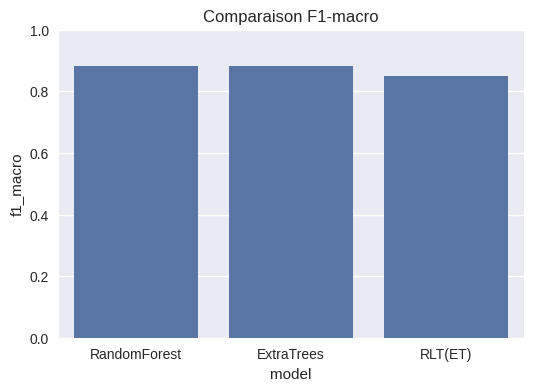

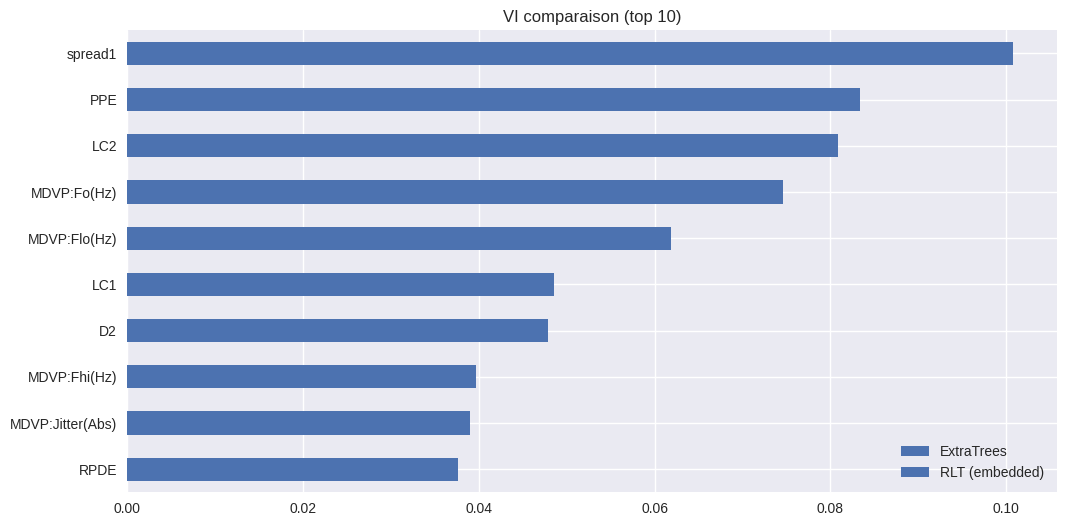

In [59]:
# Cellule 8 — Comparaison et graphes
results = {
    'model': ['RandomForest', 'ExtraTrees', 'RLT(ET)'],
    'f1_macro': [score_rf, score_et, score_rlt]
}
res_df = pd.DataFrame(results)
display(res_df)

# Plot F1
plt.figure(figsize=(6,4))
sns.barplot(data=res_df, x='model', y='f1_macro')
plt.title('Comparaison F1-macro')
plt.ylim(0,1)
plt.show()

# Plot variable importance comparison (top 10)
topn = 10
plt.figure(figsize=(12,6))
vi_et.head(topn).sort_values().plot(kind='barh', label='ExtraTrees')
vi_emb_rlt.head(topn).sort_values().plot(kind='barh', label='RLT (embedded)')
plt.title("VI comparaison (top {})".format(topn))
plt.legend()
plt.show()


Interprétation & proposition d'amélioration (texte automatique)

In [60]:

print("=== INTERPRÉTATION AUTOMATIQUE ===\n")
print(f"RF F1-macro: {score_rf:.4f}")
print(f"ET F1-macro: {score_et:.4f}")
print(f"RLT F1-macro: {score_rlt:.4f}\n")

print("Top features identifiées par ExtraTrees (global) :")
display(vi_et.head(10))

print("\nTop features identifiées par RLT (embedded) :")
display(vi_emb_rlt.head(10))

print("\nProposition d'amélioration :")
print("- Tester la version muting 'full' pour vérifier si supprimer p2 améliore la généralisation.")
print("- Essayer ICA au lieu de PCA pour les linear combinations (capturer non-gaussianités).")
print("- Réaliser un GridSearchCV (ou RandomizedSearchCV) pour optimiser les hyperparamètres de ExtraTrees/RF.")
print("- Effectuer validation croisée stratifiée (k-fold) et rapporter moyenne ± std des métriques.")
print("- Tester l'usage de SHAP pour expliquer localement les prédictions des patients.")


=== INTERPRÉTATION AUTOMATIQUE ===

RF F1-macro: 0.8828
ET F1-macro: 0.8828
RLT F1-macro: 0.8485

Top features identifiées par ExtraTrees (global) :


,0
spread1,0.100723
MDVP:Fo(Hz),0.083375
PPE,0.080826
MDVP:Flo(Hz),0.074574
D2,0.052356
MDVP:Fhi(Hz),0.048532
MDVP:Jitter(Abs),0.040246
RPDE,0.039651
spread2,0.039010
DFA,0.037680



Top features identifiées par RLT (embedded) :


,0
spread1,0.084575
PPE,0.078944
LC2,0.068890
MDVP:Fo(Hz),0.068291
MDVP:Flo(Hz),0.061907
LC1,0.048380
D2,0.047861
MDVP:Fhi(Hz),0.039529
MDVP:Jitter(Abs),0.036729
RPDE,0.034605



Proposition d'amélioration :
- Tester la version muting 'full' pour vérifier si supprimer p2 améliore la généralisation.
- Essayer ICA au lieu de PCA pour les linear combinations (capturer non-gaussianités).
- Réaliser un GridSearchCV (ou RandomizedSearchCV) pour optimiser les hyperparamètres de ExtraTrees/RF.
- Effectuer validation croisée stratifiée (k-fold) et rapporter moyenne ± std des métriques.
- Tester l'usage de SHAP pour expliquer localement les prédictions des patients.


Amélioration :

Tester Muting = "full"

In [61]:
# =============================
# TEST MUTING FULL
# =============================
print("\n==== TEST MUTING MODE: FULL ====\n")

# Muting FULL (p2 = supprimé complètement)
X_trainMF = apply_muting(X_train, p0, p1, p2, mode="full")
X_testMF  = apply_muting(X_test,  p0, p1, p2, mode="full")

# Linear combinations avec PCA
X_trainLCF = add_linear_combinations(X_trainMF, method="pca")
X_testLCF  = add_linear_combinations(X_testMF, method="pca")

# RLT Forest avec muting full
rlt_model_full, rlt_preds_full = rlt_forest(X_trainLCF, y_train, X_testLCF)
score_full = f1_score(y_test, rlt_preds_full, average="macro")

print(f"🎯 F1-macro RLT (muting FULL): {score_full:.4f}")



==== TEST MUTING MODE: FULL ====

🎯 F1-macro RLT (muting FULL): 0.9414


PCA vs ICA (Linear Combinations)

In [62]:
# =============================
# PCA vs ICA COMPARISON
# =============================
print("\n==== TEST PCA vs ICA ====\n")

scores_lc = {}

for method in ["pca", "ica"]:
    X_trainLC = add_linear_combinations(X_trainM, method=method)
    X_testLC  = add_linear_combinations(X_testM, method=method)

    model, preds = rlt_forest(X_trainLC, y_train, X_testLC)
    score = f1_score(y_test, preds, average="macro")

    scores_lc[method] = score
    print(f"{method.upper()} → F1-macro = {score:.4f}")

scores_lc



==== TEST PCA vs ICA ====

PCA → F1-macro = 0.8485
ICA → F1-macro = 0.8485


{'pca': 0.8484848484848484, 'ica': 0.8484848484848484}

GridSearchCV (ExtraTrees / RandomForest)

In [63]:
# =============================
# GRID SEARCH EXTRA TREES
# =============================
from sklearn.model_selection import GridSearchCV

print("\n==== GRID SEARCH EXTRA TREES ====\n")

grid_params = {
    "n_estimators": [200, 400, 600],
    "max_features": ["sqrt", "log2", None],
    "criterion": ["gini", "entropy"]
}

et = ExtraTreesClassifier(random_state=42)

grid = GridSearchCV(
    et,
    grid_params,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("🔥 Best Params:", grid.best_params_)
print("🔥 Best Score (CV):", grid.best_score_)



==== GRID SEARCH EXTRA TREES ====

🔥 Best Params: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}
🔥 Best Score (CV): 0.9044862486675622


Stratified K-Fold Cross Validation (tous modèles)

In [64]:
# =============================
# STRATIFIED K-FOLD CV
# =============================
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
}

results = {}

for name, model in models.items():
    scores = []

    for train_idx, test_idx in skf.split(X, y):
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(Xtr, ytr)
        preds = model.predict(Xte)
        scores.append(f1_score(yte, preds, average="macro"))

    results[name] = (np.mean(scores), np.std(scores))

results


{'RandomForest': (np.float64(0.8311440393613363),
  np.float64(0.10286383286423931)),
 'ExtraTrees': (np.float64(0.8833585730199796),
  np.float64(0.07712005897461405))}

SHAP (Interprétation locale + globale)

In [65]:
!pip install shap

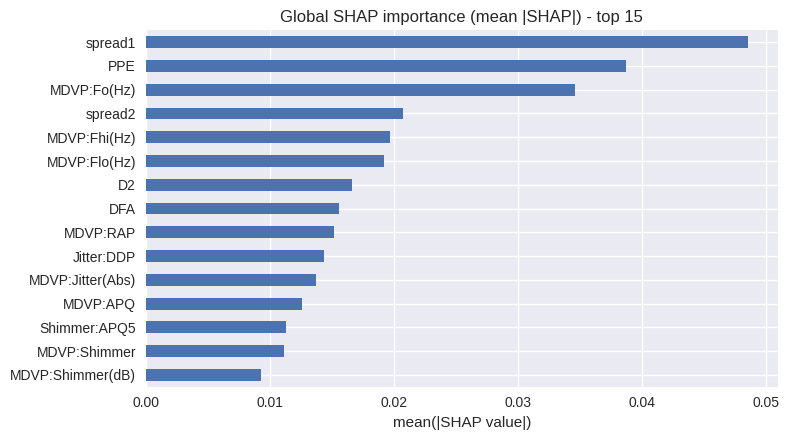


Local explanation for instance index=5 (top 12):


,feature,value,shap,abs_shap
18,spread1,-5.657899,0.034420,0.034420
19,spread2,0.315903,0.019233,0.019233
21,PPE,0.200423,0.019180,0.019180
12,MDVP:APQ,0.028770,0.015218,0.015218
2,MDVP:Flo(Hz),155.495000,0.013301,0.013301
20,D2,3.098256,0.013226,0.013226
0,MDVP:Fo(Hz),180.978000,0.012067,0.012067
4,MDVP:Jitter(Abs),0.000020,0.011458,0.011458
11,Shimmer:APQ5,0.024930,0.010318,0.010318
17,DFA,0.727747,0.009840,0.009840


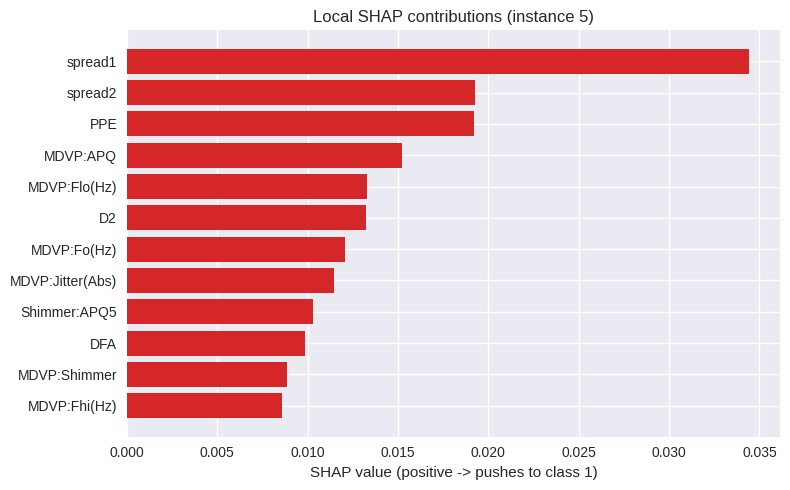

In [66]:
# Robust SHAP evaluation without interactive plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# --- prepare a clean baseline model if not present ---
try:
    et_clean
    X_test_clean
    X_train_clean
    y_train_clean
except NameError:
    cols_to_remove = [c for c in ['name', 'status'] if c in df.columns]
    X_all = df.drop(cols_to_remove, axis=1)
    y_all = df['status']
    X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )
    et_clean = ExtraTreesClassifier(n_estimators=300, random_state=42)
    et_clean.fit(X_train_clean, y_train_clean)

# --- compute shap values robustly ---
explainer = None
shap_values = None
try:
    # try new Explainer (works well for many models)
    explainer = shap.Explainer(et_clean, X_train_clean, feature_names=X_train_clean.columns)
    ev = explainer(X_test_clean)   # returns Explanation object
    # convert to numpy for compatibility below
    # ev.values shape: (n_samples, n_outputs?, n_features) OR (n_samples, n_features)
    # We'll extract a 2D array shap_arr with shape (n_samples, n_features) for class=1 if needed
    if hasattr(ev, "values") and ev.values is not None:
        vals = np.array(ev.values)
        # if last dim is classes, pick positive class when possible
        if vals.ndim == 3:
            # (n_samples, n_classes, n_features) or (n_samples, n_features, n_classes) — normalize:
            # try common formats:
            if vals.shape[1] == 2 and vals.shape[2] == X_test_clean.shape[1]:
                # shape (n_samples, n_classes, n_features)
                shap_arr = vals[:, 1, :]   # class 1
            elif vals.shape[2] == 2 and vals.shape[1] == X_test_clean.shape[1]:
                # shape (n_samples, n_features, n_classes)
                shap_arr = vals[:, :, 1]
            else:
                # fallback: squeeze last dim if possible
                shap_arr = vals.reshape(vals.shape[0], -1)[:, :X_test_clean.shape[1]]
        elif vals.ndim == 2:
            shap_arr = vals
        else:
            # last resort
            shap_arr = vals.reshape(vals.shape[0], -1)[:, :X_test_clean.shape[1]]
    else:
        raise Exception("Explainer returned no .values; fallback.")
except Exception:
    # fallback to TreeExplainer (older API)
    explainer = shap.TreeExplainer(et_clean)
    svals = explainer.shap_values(X_test_clean)  # could be list or array
    if isinstance(svals, list):
        # assume binary: svals[1] is class 1 (shape n_samples x n_features) OR shape (n_samples, n_features, 1)
        cand = svals[1]
        cand = np.array(cand)
        if cand.ndim == 3:
            # handle shape (n_samples, 1, n_features) or (n_samples, n_features, 1)
            if cand.shape[1] == 1 and cand.shape[2] == X_test_clean.shape[1]:
                shap_arr = cand[:,0,:]
            elif cand.shape[2] == 1 and cand.shape[1] == X_test_clean.shape[1]:
                shap_arr = cand[:,:,0]
            else:
                shap_arr = cand.reshape(cand.shape[0], -1)[:, :X_test_clean.shape[1]]
        elif cand.ndim == 2:
            shap_arr = cand
        else:
            shap_arr = cand.reshape(cand.shape[0], -1)[:, :X_test_clean.shape[1]]
    else:
        arr = np.array(svals)
        if arr.ndim == 3:
            # try to pick last axis as class
            if arr.shape[1] == X_test_clean.shape[1]:
                shap_arr = arr[:, :, 1] if arr.shape[2] == 2 else arr[:, :, 0]
            else:
                shap_arr = arr.reshape(arr.shape[0], -1)[:, :X_test_clean.shape[1]]
        elif arr.ndim == 2:
            shap_arr = arr
        else:
            shap_arr = arr.reshape(arr.shape[0], -1)[:, :X_test_clean.shape[1]]

# now shap_arr should be (n_samples, n_features)
assert shap_arr.shape[1] == X_test_clean.shape[1], f"shap/features mismatch: {shap_arr.shape} vs {X_test_clean.shape}"

# --- global importance: mean(|shap|) per feature ---
shap_abs_mean = np.abs(shap_arr).mean(axis=0)
vi_shap = pd.Series(shap_abs_mean, index=X_test_clean.columns).sort_values(ascending=False)

# plot top features (matplotlib, robust)
topn = min(15, len(vi_shap))
plt.figure(figsize=(8, max(4, topn*0.3)))
vi_shap.head(topn).sort_values().plot(kind='barh')
plt.title("Global SHAP importance (mean |SHAP|) - top {}".format(topn))
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.show()

# --- local explanation for one instance (table + bar) ---
idx = 5 if X_test_clean.shape[0] > 5 else 0
local_sv = shap_arr[idx]  # vector length n_features
local_df = pd.DataFrame({
    "feature": X_test_clean.columns,
    "value": X_test_clean.iloc[idx].values,
    "shap": local_sv
})
local_df['abs_shap'] = np.abs(local_df['shap'])
local_df = local_df.sort_values('abs_shap', ascending=False)

# show top contributing features for this instance
print(f"\nLocal explanation for instance index={idx} (top 12):")
display(local_df.head(12))

# barplot of positive vs negative contribution (top 12)
top_local = local_df.head(12).sort_values('shap')
plt.figure(figsize=(8,5))
colors = ['#d62728' if x>0 else '#1f77b4' for x in top_local['shap']]  # red positive (push toward class1), blue negative
plt.barh(top_local['feature'], top_local['shap'], color=colors)
plt.title(f"Local SHAP contributions (instance {idx})")
plt.xlabel("SHAP value (positive -> pushes to class 1)")
plt.tight_layout()
plt.show()
